## Plain Gradient Descent with Fixed Learning Rate

We consider the Mean Squared Error (MSE) cost function for Ordinary Least Squares (OLS) regression:

$$ C(\beta) = \frac{1}{n}(\mathbf{X}\beta - \mathbf{y})^T(\mathbf{X}\beta - \mathbf{y}) $$

The analytical gradient is given by:

$$ \nabla C(\beta) = \frac{2}{n}\mathbf{X}^T(\mathbf{X}\beta - \mathbf{y}) $$

The parameter update rule for plain gradient descent is:

$$ \beta = \beta - \eta \nabla C(\beta) $$

where $ \eta $ is the learning rate.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ml_p2.visualization import plot_eval_metric_vs_iter
from ml_p2 import regression as reg
from ml_p2.utils import repeat_experiment


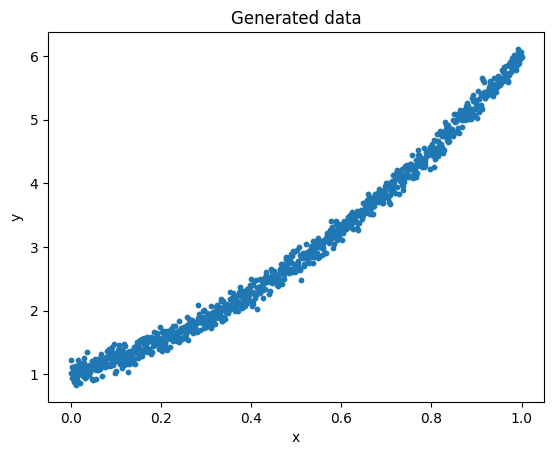

In [2]:
def generate_data(n_samples):
    x = np.linspace(0, 1, n_samples)
    y = 1 + 2 * x + 3 * x**2 + np.random.normal(0, 0.1, n_samples)
    return x, y


x, y = generate_data(1000)
X = np.column_stack((np.ones(len(x)), x))
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

plt.scatter(x, y, s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data")
plt.show()

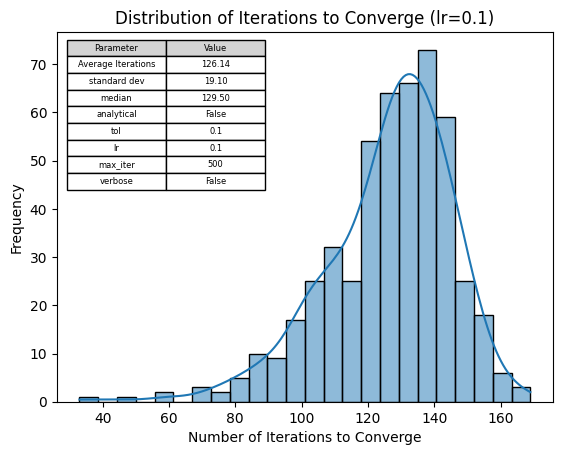

{'mean': np.float64(126.142),
 'std': np.float64(19.101147504796668),
 'median': np.float64(129.5)}

In [3]:

learning_rate = 0.1
tolerance = 0.1
max_iterations = 500
params_plain = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tolerance,
}

repeat_experiment(
    reg.Plain_GD,
    X=X_train,
    y=y_train,
    n_exp=500,
    tol=tolerance,
    lr=learning_rate,
    max_iter=max_iterations,
    verbose=False,
)

Converged in 106 iterations


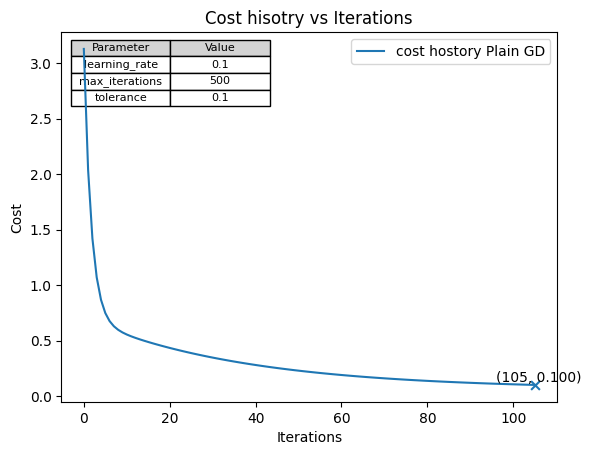

In [4]:
ch_plain, iter = reg.Plain_GD(
    X_train,
    y_train,
    tol=tolerance,
    max_iter=max_iterations,
    lr=learning_rate,
)

plot_eval_metric_vs_iter(ch_plain,params_plain, "cost hostory Plain GD")

### Newton's Method Using the Hessian Matrix

While gradient descent uses first-order derivatives to find the minimum of a function, Newton's method leverages second-order derivatives (the Hessian matrix) for potentially faster convergence.

The update rule for Newton's method is:

$$ \beta = \beta - H^{-1}(\beta) \nabla C(\beta) $$

where:

- $\nabla C(\beta)$ is the gradient vector.
- $H(\beta) $ is the Hessian matrix of second derivatives.

For the MSE cost function in OLS regression, the Hessian matrix is given by:

$$ H(\beta) = \frac{2}{n} \mathbf{X}^T \mathbf{X} $$

Newton's method can achieve quadratic convergence near the optimum, but it requires computation of the Hessian and its inverse, which can be computationally intensive for large datasets.


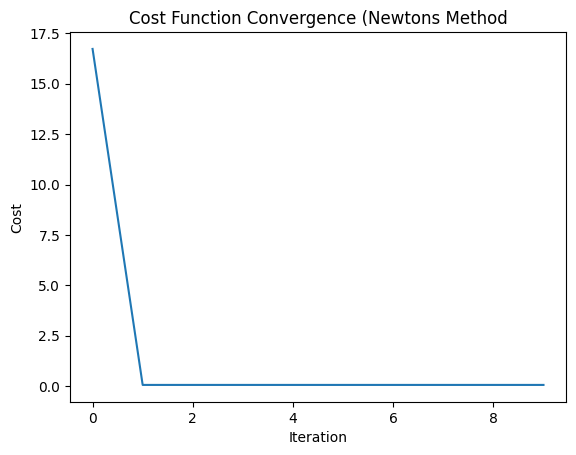

Minimum cost: 0.06178653653637487


In [5]:
beta_newton = np.random.randn(X.shape[1], 1)
n_iterations_newton = 10
cost_history_newton = []

# Precompute the Hessian matrix and its inverse
H = (2 / len(y)) * X.T @ X
H_inv = np.linalg.inv(H)

### Using the eigen value of Hessian matrix to calculate the learning rate
### Instead of using the inverse of the Hessian matrix
# H_eign_values, H_Eign_vec = np.linalg.eig(H)
# max_eign = np.max(H_eign_values)
# inver_max_eign = 1 / max_eign

for i in range(n_iterations_newton):
    y_pred = X @ beta_newton
    error = y_pred - y
    cost = (1 / len(y)) * np.sum(error**2)
    cost_history_newton.append(cost)
    gradient = (2 / len(y)) * X.T @ error
    beta_newton -= H_inv @ gradient
    # beta_newton -= inver_max_eign * gradient

plt.plot(range(n_iterations_newton), cost_history_newton)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function Convergence (Newtons Method")
plt.show()

print("Minimum cost:", cost_history_newton[-1])

## Adding Momentum to Gradient Descent

To accelerate convergence, we can add **momentum** to the gradient descent algorithm. Momentum helps by considering the previous update's direction and magnitude, smoothing out the updates, and potentially leading to faster convergence.

The momentum update equations are:

$$ v*t = \gamma v*{t-1} + \eta \nabla C(\beta) $$
$$ \beta\_{j+1} = \beta_j - v_t $$

where:

- $ v_t $ is the velocity vector at iteration $ t $.
- $ \gamma $ is the momentum coefficient (typically between 0 and 1).
- $ \eta $ is the learning rate.
- $ \nabla C(\beta_j) $ is the gradient of the cost function.

Our goal is to find the parameters $ \beta $ that minimize the cost function using gradient descent with a fixed learning rate, and to compare the convergence with and without momentum.


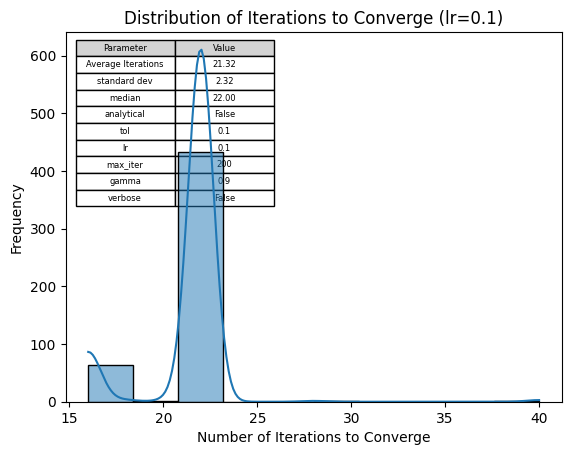

{'mean': np.float64(21.316),
 'std': np.float64(2.315198479612493),
 'median': np.float64(22.0)}

In [6]:
learning_rate = 0.1
max_iterations = 200
tolerance = 0.1
gamma = 0.9

params_mom_plain = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tolerance,
    "gamma": gamma,
}

repeat_experiment(
    reg.momentum_gd,
    X=X_train,
    y=y_train,
    n_exp=500,
    tol=tolerance,
    lr=learning_rate,
    max_iter=max_iterations,
    gamma=gamma,
    verbose=False,
)


Converged in 22 iterations


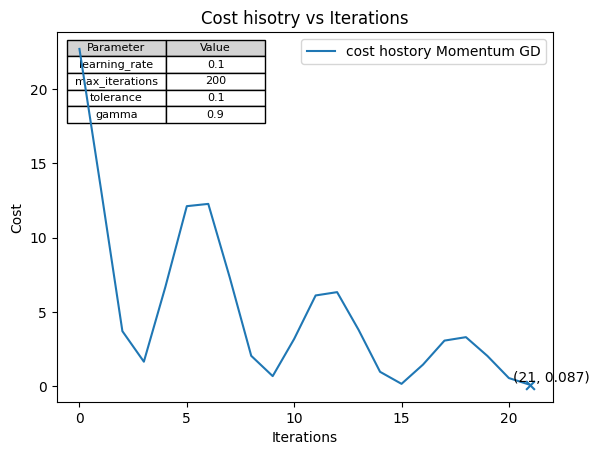

In [7]:
ch_mom, iter = reg.momentum_gd(
    X_train,
    y_train,
    tol=tolerance,
    max_iter=max_iterations,
    lr=learning_rate,
    gamma=gamma,
)

plot_eval_metric_vs_iter(ch_mom, params_mom_plain, "cost hostory Momentum GD")

## Stockastic Gradient Descent (SGD)

In the context of large datasets, computing the gradient of the cost function using the entire dataset can be computationally expensive. Stockastic Gradient Descent (SGD) addresses this issue by computing the gradient using a single sample or a small batch of samples at each iteration.

The update rule for SGD is:

The idea behind SGD comes from the observation that the cost function which we want to minimize, can almost always be written
as a sum of cost functions for each individual data point.

$$C(\beta) = \sum_{i=1}^{n} c_i(x_i,\beta)$$

where $C_i(\beta)$ is the cost function for the $i$-th data point.

This in turn implies that the gradient of the cost function can be written as a sum of gradients of the individual data points:

$$\nabla_{\beta} C(\beta) = \sum_{i=1}^{n} \nabla_{\beta} c_i(x_i,\beta)$$

The idea now is to approximate the gradient of the cost function by sum over all data points in one mini-batch picked at random in each iteration. This is called Stochastic Gradient Descent (SGD).

$$\nabla_{\beta} C(\beta)  = \sum_{i=1}^{n} \nabla_{\beta} c_i(x_i,\beta) -> \sum_{i\in B} \nabla_{\beta} c_i(x_i,\beta)$$

where $B$ is the mini-batch of data points.

The update rule for SGD is:

$$ \beta_{j+1} = \beta_j - \eta \sum_{i\in B} \nabla_{\beta} c_i(x_i,\beta) $$

where $i$ is a random index from the mini-batch $B$.

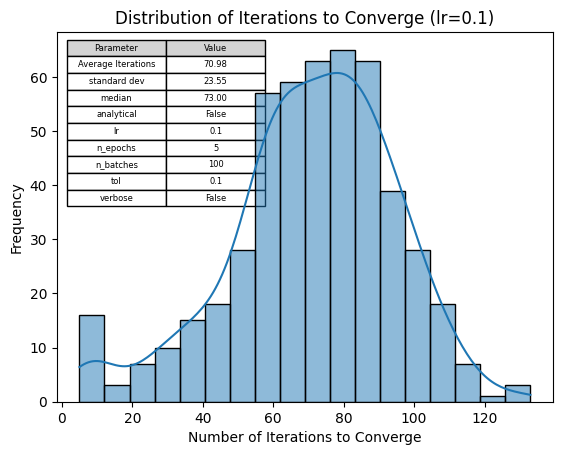

{'mean': np.float64(70.984),
 'std': np.float64(23.55410248767717),
 'median': np.float64(73.0)}

In [8]:
learning_rate = 0.1
n_epochs = 5
n_batches = 100
tolerance = 0.1

params_sgd = {
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "n_batches": n_batches,
    "tolerance": tolerance,
}

repeat_experiment(
    reg.Stochastic_GD,
    X=X_train,
    y=y_train,
    n_exp=500,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tolerance,
    verbose=False,
)


Converged in 76 iterations


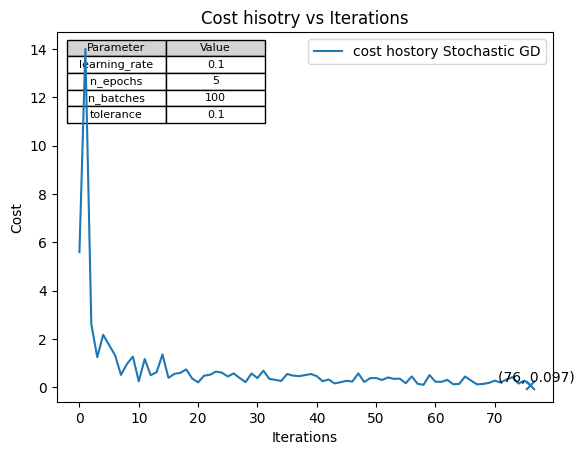

In [9]:
ch_sgd,iter = reg.Stochastic_GD(
    X_train,
    y_train,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tolerance,
)

plot_eval_metric_vs_iter(ch_sgd, params_sgd, "cost hostory Stochastic GD")

##


## Adaptive Gradient Algorithm (AdaGrad)

Adapts the learning rate for each parameter individually, scales the the learning rate based on the historical sum squared gradients for each parameter. allows for larger updates for infrequent parameters and smaller updates for frequent parameters.

1. Initialize the sum of squared gradients $G_0= 0$.

2. Update the accumulator at each iteration:
   $$ G_t = G_{t-1} + (\nabla C(\beta_t))^2 $$

It is done element-wise for each parameter, so each parameter $ \beta_i $ has it's own accumulator $ G_{t,i} $.

3. Update the parameters:

$$ \beta_{t+1} = \beta_t - \frac{\eta}{\sqrt{G_t}+ \epsilon} \nabla C(\beta_t) $$

where:

- $ \eta $ is the global learning rate.
- $ \epsilon $ is a small constant to prevent division by zero.


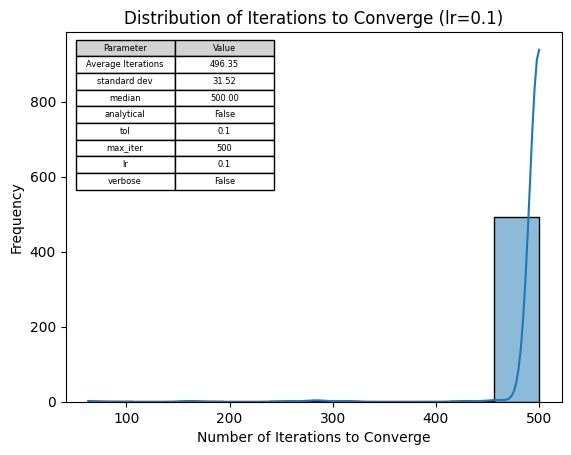

{'mean': np.float64(496.346),
 'std': np.float64(31.518221459974544),
 'median': np.float64(500.0)}

In [10]:
learning_rate = 0.1
tol = 0.1
max_iterations = 500

repeat_experiment(
    reg.adagrad_plain,
    X=X_train,
    y=y_train,
    n_exp=500,
    tol = tol,
    max_iter = max_iterations,
    lr=learning_rate,
    verbose=False,
)



Did not converge, consider increasing max_iter or increasing learning rate


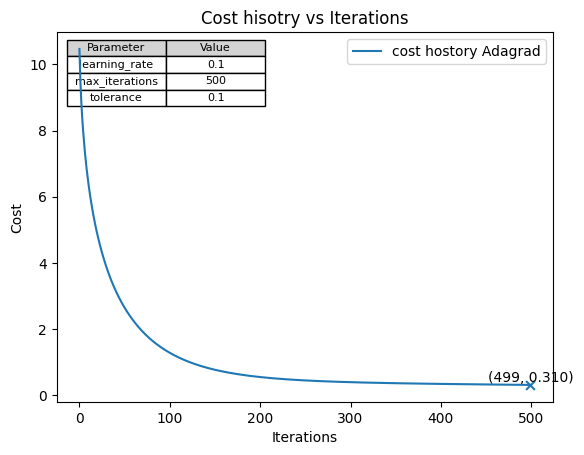

In [11]:
params_adagrad = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tol,
}

ch_ada, iter = reg.adagrad_plain(
    X_train,
    y_train,
    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
)

plot_eval_metric_vs_iter(ch_ada, params_adagrad, "cost hostory Adagrad")

## Adding momentum to AdaGrad

Velocity update equation for AdaGrad with momentum:

$$ v_t = \gamma v_{t-1} + \frac{\eta}{\sqrt{G_{t+1} }+ \epsilon} \nabla C(\beta_t) $$

where

- $ \gamma $ is the momentum coefficient.

Parameter update equation for AdaGrad with momentum:

$$ \beta_{j+1} = \beta_j - v_t $$


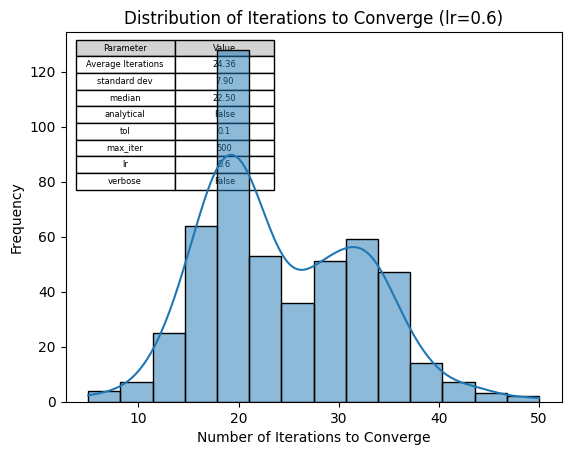

{'mean': np.float64(24.356),
 'std': np.float64(7.901219146435568),
 'median': np.float64(22.5)}

In [12]:
learning_rate = 0.6
tol = 0.1
max_iterations = 500

repeat_experiment(
    reg.adagrad_momentum_plain,
    X=X_train,
    y=y_train,
    n_exp=500,
    tol = tol,
    max_iter = max_iterations,
    lr=learning_rate,
    verbose=False,
)

Converged in 31 iterations


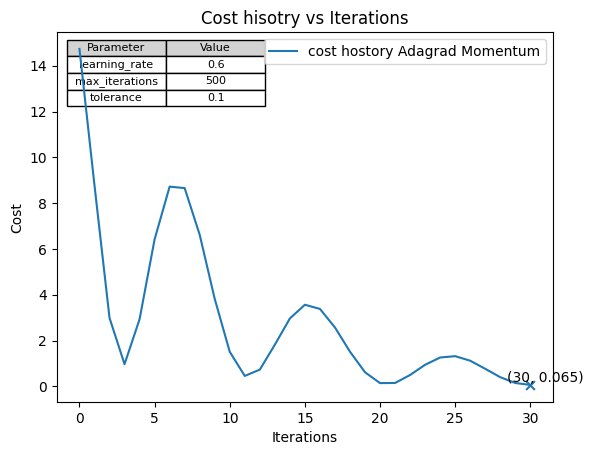

In [13]:
params_sgd_mom = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tol,
}

ch_ada_mom, iter = reg.adagrad_momentum_plain(
    X_train,
    y_train,
    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
)

plot_eval_metric_vs_iter(ch_ada_mom, params_sgd_mom, "cost hostory Adagrad Momentum")

## AdaGrad with Stochastic Gradient Descent

AdaGrad (Adaptive Gradient) is an optimization algorithm that adjusts the learning rate for each parameter individually during training. It is an extension of stochastic gradient descent (SGD) that improves convergence when dealing with sparse data and features.

SGD updates model parameters using gradients computed from mini-batches of data. While effective, it uses a global learning rate that may not be optimal for all parameters, especially in cases where some features are infrequent.

### The AdaGrad Algorithm

AdaGrad adapts the learning rate for each parameter based on the accumulated squared gradients from all previous steps. The update rule for parameter \( \beta_i \) at time step \( t \) is:

$$ \beta_{j+1} = \beta_{j} - \frac{\eta}{\sqrt{G_{t} }+ \epsilon} \, \sum_{i\in B} \nabla_{\beta} c_i(x_i,\beta)  $$

where:

- $ \eta $ is the global learning rate.
- $ G_{t} $ is the accumulated sum of squared gradients up to time step $ t $.
- $ \epsilon $ is a small constant to prevent division by zero.
- $ \nabla_{\beta} c_i(x_i,\beta) $ is the gradient of the cost function random index $ i $ from the mini-batch $ B $.




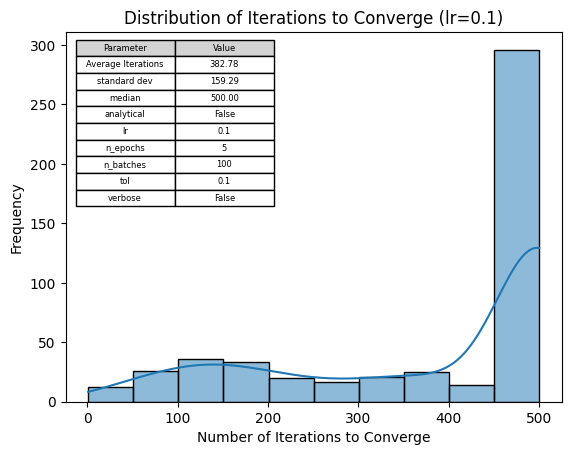

{'mean': np.float64(382.784),
 'std': np.float64(159.2855088951911),
 'median': np.float64(500.0)}

In [14]:
learning_rate = 0.1
n_epochs = 5
n_batches = 100

repeat_experiment(
    reg.adagrad_sgd,
    X=X_train,
    y=y_train,
    n_exp=500,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tol,
    verbose=False,
)

Converged in 307 iterations


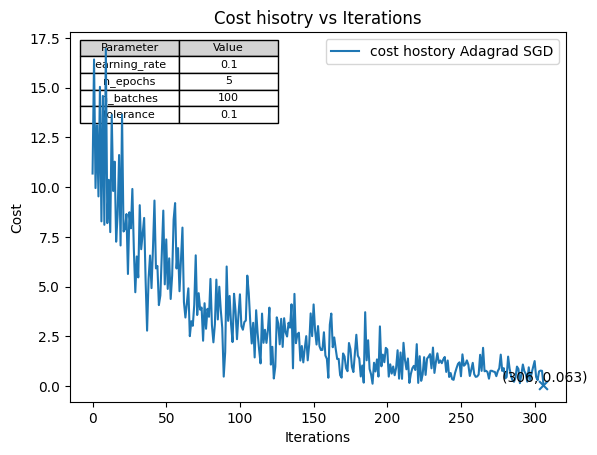

In [15]:
params_adagrad_sgd = {
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "n_batches": n_batches,
    "tolerance": tol,
}

ch_ada_sgd, iter = reg.adagrad_sgd(
    X_train,
    y_train,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tol,
)

plot_eval_metric_vs_iter(ch_ada_sgd, params_adagrad_sgd, "cost hostory Adagrad SGD")

## Adding momentum to AdaGrad with Stochastic Gradient Descent
Here we use the stochastic approximated gradient to update the velocity momentum term. The update rule for the velocity term is:

$$ v_t = \gamma v_{t-1} + \frac{\eta}{\sqrt{G_{t+1} }+ \epsilon} \sum_{i\in B} \nabla_{\beta} c_i(x_i,\beta) $$

where:

- $ \gamma $ is the momentum coefficient.
- $ v_t $ is the velocity vector at iteration $ t $.
- $ \eta $ is the learning rate.
- $ G_{t+1} $ is the accumulated sum of squared gradients up to time step $ t+1 $.
- $ \epsilon $ is a small constant to prevent division by zero.
- $ \nabla_{\beta} c_i(x_i,\beta) $ is the gradient of the cost function for random index $ i $ from the mini-batch $ B $.

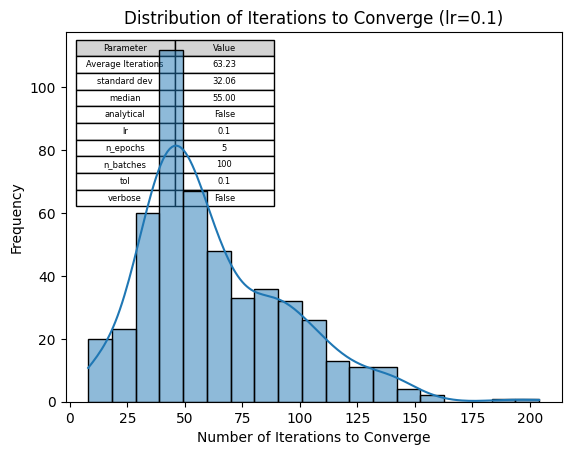

{'mean': np.float64(63.228),
 'std': np.float64(32.05514024302499),
 'median': np.float64(55.0)}

In [16]:
learning_rate = 0.1
tol = 0.1
max_iterations = 500
n_batches = 100
n_epochs = 5

repeat_experiment(
    reg.adagrad_momentum_sgd,
    X=X_train,
    y=y_train,
    n_exp=500,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tol,
    verbose=False,
)


Converged in 83 iterations


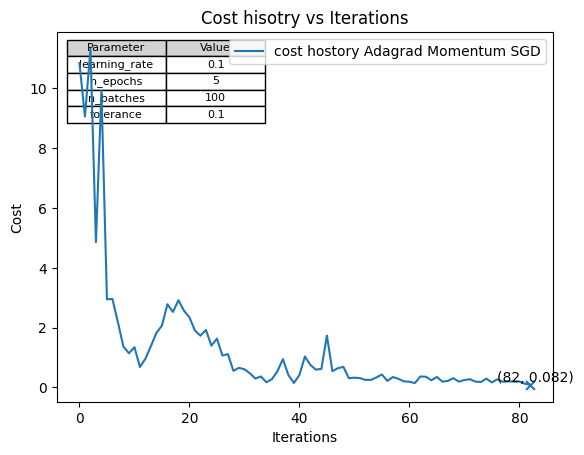

In [17]:
params_adagrad_mom_sgd = {
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "n_batches": n_batches,
    "tolerance": tol,
}

ch_ada_mom_sgd, iter = reg.adagrad_momentum_sgd(
    X_train,
    y_train,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tol,
)

plot_eval_metric_vs_iter(ch_ada_mom_sgd, params_adagrad_mom_sgd, "cost hostory Adagrad Momentum SGD")

## Root Mean Squared Propagation (RMSProp)

RMSProp adresses the diminishing learning rate problem in AdaGrad by using a moving average of squared gradients. That is changing the accumulator to be a moving average of squared gradients.

1. Initialize the moving average of squared gradients $E[g^2]_0 = 0$.

2. Update the moving average at each iteration:

$$ E[g^2]_t = \rho E[g^2]_{t-1} + (1-\rho)(\nabla C(\beta_t))^2 $$

where:

- $ \rho $ is the moving average decay factor. typically close to 0.9.
- $ (\nabla C(\beta_t))^2 $ is performed element-wise for each parameter.

3. Update the parameters:

$$ \beta_{t+1} = \beta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \nabla C(\beta_t) $$

where:

- $ \eta $ is the global learning rate.
- $ \epsilon $ is a small constant to prevent division by zero.


## RMSProp on plain Gradient Descent


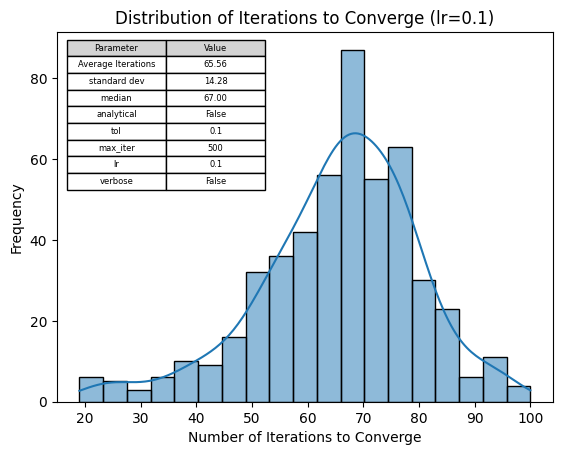

{'mean': np.float64(65.56),
 'std': np.float64(14.283220925267521),
 'median': np.float64(67.0)}

In [18]:
learning_rate = 0.1
tol = 0.1
max_iterations = 500

repeat_experiment(
    reg.rmsprop_plain,
    X=X_train,
    y=y_train,
    n_exp=500,

    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
    verbose=False,
)



Converged in 87 iterations


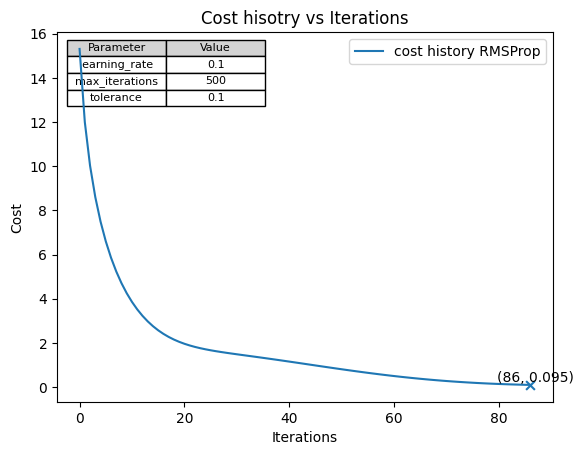

In [20]:
params_rmpsprop = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tol,
}

ch_rmsprop, iter = reg.rmsprop_plain(
    X_train,
    y_train,
    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
)

plot_eval_metric_vs_iter(ch_rmsprop, params_rmpsprop, "cost history RMSProp")

## RMSProp with Stochastic Gradient Descent

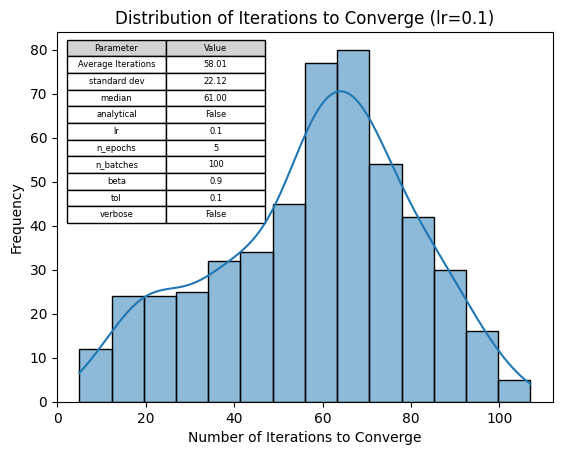

{'mean': np.float64(58.014),
 'std': np.float64(22.12134272597394),
 'median': np.float64(61.0)}

In [21]:
learning_rate = 0.1
tol = 0.1
max_iterations = 500
n_epochs = 5
n_batches = 100
beta = 0.9


repeat_experiment(
    reg.rmsprop_sgd,
    X=X_train,
    y=y_train,
    n_exp=500,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    beta=beta,
    tol=tol,
    verbose=False,
)


## Adam Adaptive Moment Estimation Optimizer

Adam combines the ideas from RMSProp and momentum. It computes adaptive learning rates for each parameter by using the moving average of both the first and second moments of the gradients.

1. Initialize the first and second moment estimates $m_0 = 0$ and $v_0 = 0$.

2. At each iteration $t$:
   - Compute the gradient $g_t = \nabla C(\beta_t)$.
   - Update the biased first moment estimate:
     $$ m*t = \beta_1 m*{t-1} + (1-\beta_1)g_t $$
   - Update the biased second moment estimate:
     $$ v*t = \beta_2 v*{t-1} + (1-\beta_2)g_t^2 $$
   - Correct the bias:
     $$ \hat{m}\_t = \frac{m_t}{1-\beta_1^t} $$
    $$ \hat{v}\_t = \frac{v_t}{1-\beta_2^t} $$
   - Update the parameters:
     $$ \beta\_{t+1} = \beta_t - \frac{\eta}{\sqrt{\hat{v}\_t} + \epsilon} \hat{m}\_t $$

where:

- $ \beta_1 $ and $ \beta_2 $ are the exponential decay rates for the moment estimates.
- $ \eta $ is the global learning rate.
- $ \epsilon $ is a small constant to prevent division by zero.

**Interpretation**

- The first moment estimate $m_t$ is the mean average of the gradients.
- The second moment estimate $v_t$ is the uncentered variance of the gradients.
- Bias correction is applied to account for the fact that the first and second moment estimates are initialized at zero.


## Adam


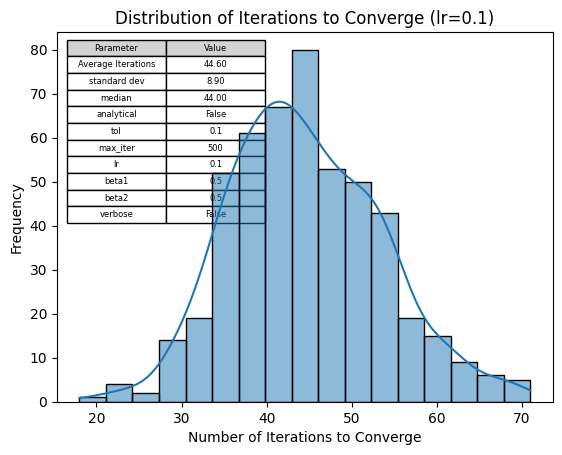

{'mean': np.float64(44.6),
 'std': np.float64(8.903033190997323),
 'median': np.float64(44.0)}

In [24]:
learning_rate = 0.1
tol = 0.1
max_iterations = 500
beta1 = 0.5
beta2 = 0.5

repeat_experiment(
    reg.adam_plain,
    X=X_train,
    y=y_train,
    n_exp=500,
    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
    beta1=beta1,
    beta2=beta2,
    verbose=False,
)

Converged in 81 iterations


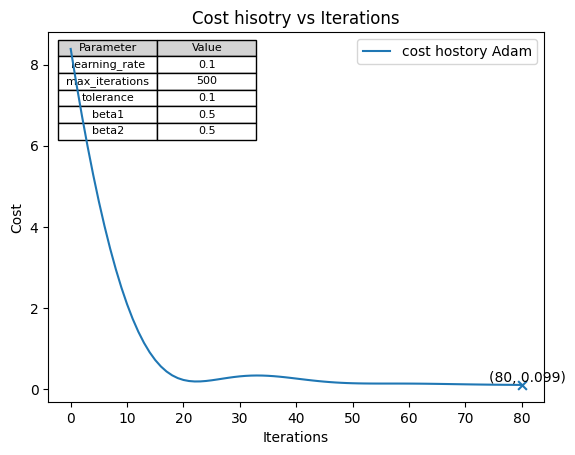

In [25]:
params_adam = {
    "learning_rate": learning_rate,
    "max_iterations": max_iterations,
    "tolerance": tol,
    "beta1": beta1,
    "beta2": beta2,
}

ch_adam, iter = reg.adam_plain(
    X_train,
    y_train,
    tol=tol,
    max_iter=max_iterations,
    lr=learning_rate,
)

plot_eval_metric_vs_iter(ch_adam, params_adam, "cost hostory Adam")

### Adam with SGD


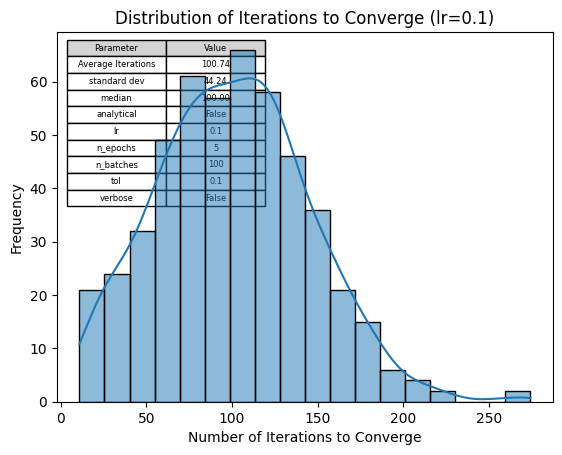

{'mean': np.float64(100.744),
 'std': np.float64(44.240552256950856),
 'median': np.float64(100.0)}

In [28]:
learning_rate = 0.1
n_epochs = 5
n_batches = 100
beta1 = 0.9
beta2 = 0.999

repeat_experiment(
    reg.adam_sgd,
    X=X_train,
    y=y_train,
    n_exp=500,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    tol=tol,
    verbose=False,
)
    

Converged in 96 iterations


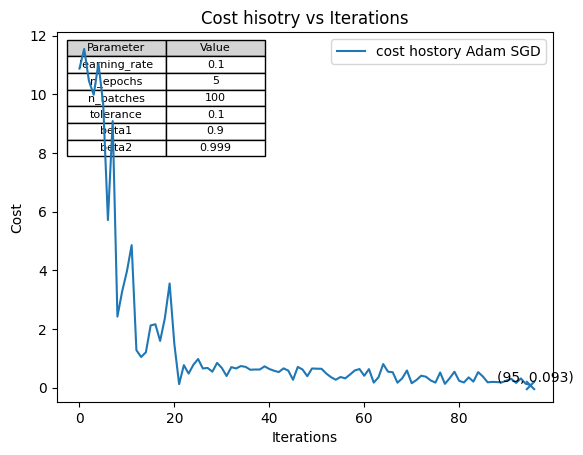

In [29]:
ch_adagm_sgd, iter = reg.adam_sgd(
    X_train,
    y_train,
    lr=learning_rate,
    n_epochs=n_epochs,
    n_batches=n_batches,
    beta1=beta1,
    beta2=beta2,
    tol=tol,
)

params_adam_sgd= {
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "n_batches": n_batches,
    "tolerance": tol,
    "beta1": beta1,
    "beta2": beta2,
}

plot_eval_metric_vs_iter(ch_adagm_sgd, params_adam_sgd, "cost hostory Adam SGD")

## Cost history comparison

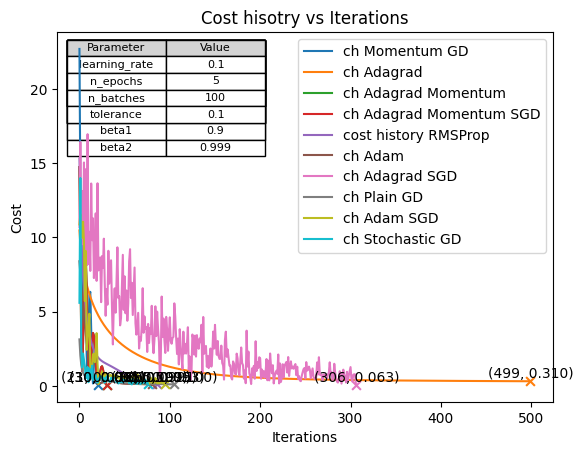

In [30]:
plot_eval_metric_vs_iter(ch_mom, params_mom_plain, "ch Momentum GD")

plot_eval_metric_vs_iter(ch_ada, params_adagrad, "ch Adagrad")
plot_eval_metric_vs_iter(ch_ada_mom, params_sgd_mom, "ch Adagrad Momentum")

plot_eval_metric_vs_iter(ch_ada_mom, params_adagrad_mom_sgd, "ch Adagrad Momentum SGD")
plot_eval_metric_vs_iter(ch_rmsprop, params_rmpsprop, "cost history RMSProp")
plot_eval_metric_vs_iter(ch_adam, params_adam, "ch Adam")


plot_eval_metric_vs_iter(ch_ada_sgd, params_adagrad_sgd, "ch Adagrad SGD")
plot_eval_metric_vs_iter(ch_plain, params_plain, "ch Plain GD")
plot_eval_metric_vs_iter(ch_adagm_sgd, params_adam_sgd, "ch Adam SGD")
plot_eval_metric_vs_iter(ch_sgd, params_sgd, "ch Stochastic GD")

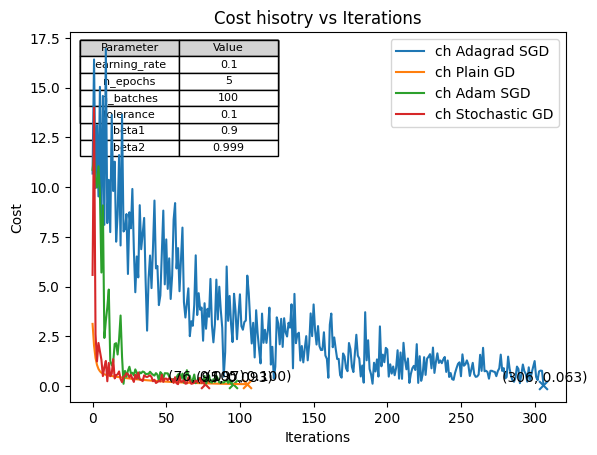

In [31]:
plot_eval_metric_vs_iter(ch_ada_sgd, params_adagrad_sgd, "ch Adagrad SGD")
plot_eval_metric_vs_iter(ch_plain, params_plain, "ch Plain GD")
plot_eval_metric_vs_iter(ch_adagm_sgd, params_adam_sgd, "ch Adam SGD")
plot_eval_metric_vs_iter(ch_sgd, params_sgd, "ch Stochastic GD")